# Importing Libraries

In [45]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import pickle
#To ignore warnings
import warnings
warnings.filterwarnings("ignore")




# Loading Dataset

In [25]:
df=pd.read_csv('/content/news_article.csv')

In [26]:
df

,Title,Content,Topic
0,Rival parties each claim edge in Pakistan elec...,But neither candidates linked to jailed ex-PM ...,Asia
1,"Against the odds, election shows Imran Khan's ...",Pakistan's vote saw candidates aligned to the ...,Asia
2,The Ukrainians 'disappearing' in Russia's prisons,Finding Ukrainian civilians in Russian captivi...,Europe
3,Gazans surviving off animal feed and rice as f...,The UN says hundreds of thousands of people in...,Middle East
4,Netanyahu orders military to plan Rafah evacua...,The Israeli PM's order comes after the US warn...,Middle East
...,...,...,...
78,Disney boss bets on Taylor Swift and Fortnite,The entertainment giant has been under pressur...,Business
79,"Bolts missing from door, says Boeing blowout p...",A door that blew away from a Boeing 737 Max ma...,Business
80,Cocoa price hits record high as El Niño hurts ...,The cost of the key ingredient for making choc...,Business
81,Uber Eats' Super Bowl ad slammed for food alle...,The Super Bowl advert faces a backlash for app...,Business


In [27]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Cleaning and Preprocessing

In [28]:
# Function to clean and preprocess text
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Tokenize and remove stop words
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return ' '.join(lemmatized_words)

# Apply preprocessing to 'Title' and 'Content' columns
df['Title'] = df['Title'].apply(preprocess_text)
df['Content'] = df['Content'].apply(preprocess_text)

In [29]:
df

,Title,Content,Topic
0,rival party claim edge pakistan election,neither candidate linked jailed imran khan riv...,Asia
1,odds election show imran khan support solid,pakistan vote saw candidate aligned former pm ...,Asia
2,ukrainian russia prison,finding ukrainian civilian russian captivity h...,Europe
3,gazans surviving animal feed rice food dwindles,un say hundred thousand people territory growi...,Middle East
4,netanyahu order military plan rafah evacuation,israeli pm order come u warned unplanned invas...,Middle East
...,...,...,...
78,disney bos bet taylor swift fortnite,entertainment giant pressure investor business,Business
79,bolt missing door say boeing blowout probe,door blew away boeing 737 max may properly sec...,Business
80,cocoa price hit record high el niño hurt crop,cost key ingredient making chocolate roughly d...,Business
81,uber eats super bowl ad slammed food allergy joke,super bowl advert face backlash appearing make...,Business


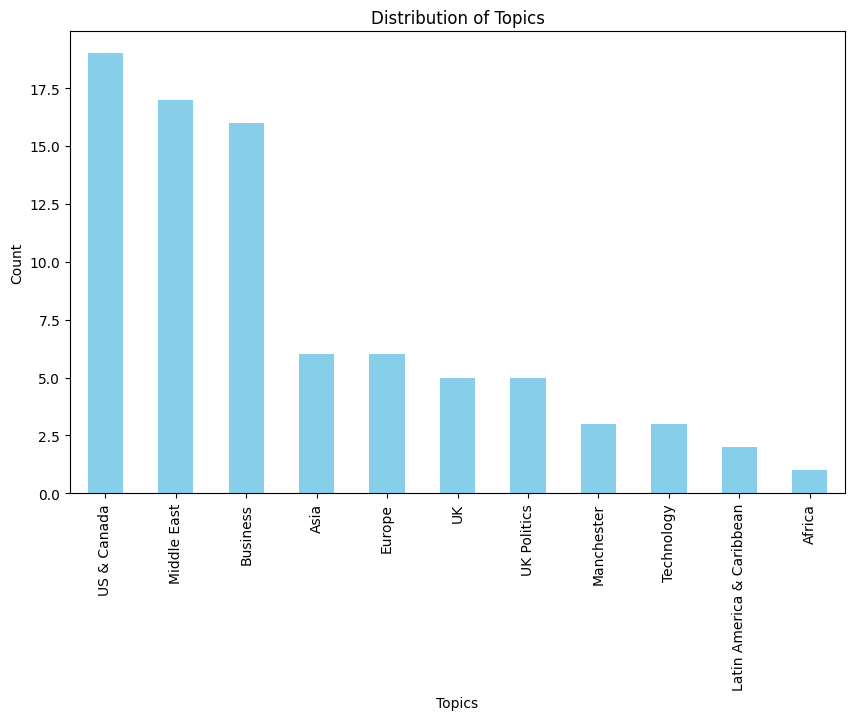

In [30]:
# Plot the distribution of topics
plt.figure(figsize=(10, 6))
df['Topic'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.show()

# Text Representation:

In [31]:
# Combine 'Title' and 'Content' into a single text column
df['Text'] = df['Title'] + ' ' + df['Content']

# TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the TF-IDF DataFrame with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1).drop(columns=['Text'])

In [32]:
df

,Title,Content,Topic,10m,11,12,13,58,737,80,...,warning,warns,way,week,west,white,working,world,writes,year
0,rival party claim edge pakistan election,neither candidate linked jailed imran khan riv...,Asia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,odds election show imran khan support solid,pakistan vote saw candidate aligned former pm ...,Asia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.257468,0.000000
2,ukrainian russia prison,finding ukrainian civilian russian captivity h...,Europe,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.261802,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,gazans surviving animal feed rice food dwindles,un say hundred thousand people territory growi...,Middle East,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,netanyahu order military plan rafah evacuation,israeli pm order come u warned unplanned invas...,Middle East,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,disney bos bet taylor swift fortnite,entertainment giant pressure investor business,Business,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
79,bolt missing door say boeing blowout probe,door blew away boeing 737 max may properly sec...,Business,0.0,0.0,0.0,0.0,0.0,0.223989,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
80,cocoa price hit record high el niño hurt crop,cost key ingredient making chocolate roughly d...,Business,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.213278
81,uber eats super bowl ad slammed food allergy joke,super bowl advert face backlash appearing make...,Business,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


# Topic Clustering:

In [33]:
from sklearn.cluster import KMeans

# Assume you want 3 clusters (adjust as needed)
num_clusters = 11

# Extract numerical features for clustering
features = df.drop(columns=['Title', 'Content', 'Topic'])

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

In [34]:
df

,Title,Content,Topic,10m,11,12,13,58,737,80,...,warns,way,week,west,white,working,world,writes,year,Cluster
0,rival party claim edge pakistan election,neither candidate linked jailed imran khan riv...,Asia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4
1,odds election show imran khan support solid,pakistan vote saw candidate aligned former pm ...,Asia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.257468,0.000000,4
2,ukrainian russia prison,finding ukrainian civilian russian captivity h...,Europe,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.261802,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3
3,gazans surviving animal feed rice food dwindles,un say hundred thousand people territory growi...,Middle East,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5
4,netanyahu order military plan rafah evacuation,israeli pm order come u warned unplanned invas...,Middle East,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,disney bos bet taylor swift fortnite,entertainment giant pressure investor business,Business,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8
79,bolt missing door say boeing blowout probe,door blew away boeing 737 max may properly sec...,Business,0.0,0.0,0.0,0.0,0.0,0.223989,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3
80,cocoa price hit record high el niño hurt crop,cost key ingredient making chocolate roughly d...,Business,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.213278,6
81,uber eats super bowl ad slammed food allergy joke,super bowl advert face backlash appearing make...,Business,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9


**ENCODING**

In [35]:
# Assuming 'df' is your DataFrame with 'Title', 'Content', and 'Topic' columns
df['Text'] = df['Title'] + ' ' + df['Content']

# Features and Target
X = df['Text']  # Features
y = df['Topic']  # Target

In [36]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

**SPLITTING**

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


# MODELS

**LogisticRegression**

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Logistic Regression
lr_pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())

# Train the model
lr_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_lr = lr_pipeline.predict(X_test)

# Print metrics
print("\nLogistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print("Classification Report:\n", classification_report(y_test, y_pred_lr))



Logistic Regression:
Accuracy: 0.8823529411764706
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         1
          10       0.60      1.00      0.75         3

    accuracy                           0.88        17
   macro avg       0.70      0.75      0.72        17
weighted avg       0.81      0.88      0.84        17



**DecisionTreeClassifier**

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Decision Tree
dt_pipeline = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

# Train the model
dt_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_dt = dt_pipeline.predict(X_test)

# Print metrics
print("\nDecision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))





Decision Tree:
Accuracy: 0.9411764705882353
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         1
          10       0.75      1.00      0.86         3

    accuracy                           0.94        17
   macro avg       0.84      0.88      0.86        17
weighted avg       0.90      0.94      0.92        17



**RandomForestClassifier**

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Random Forest
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

# Train the model
rf_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_pipeline.predict(X_test)

# Print metrics
print("\nRandom Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest:
Accuracy: 0.9411764705882353
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         1
          10       0.75      1.00      0.86         3

    accuracy                           0.94        17
   macro avg       0.84      0.88      0.86        17
weighted avg       0.90      0.94      0.92        17



**MultinomialNB**

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Multinomial Naive Bayes
nb_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
nb_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_nb = nb_pipeline.predict(X_test)

# Print metrics
print("\nMultinomial Naive Bayes:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))



Multinomial Naive Bayes:
Accuracy: 0.8823529411764706
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           6       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         1
          10       0.75      1.00      0.86         3

    accuracy                           0.88        17
   macro avg       0.70      0.75      0.72        17
weighted avg       0.79      0.88      0.83        17



**SUPPORT VECTOR MACHINE**

In [42]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Support Vector Machine
svm_pipeline = make_pipeline(TfidfVectorizer(), SVC())

# Train the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_svm = svm_pipeline.predict(X_test)

# Print metrics
print("\nSupport Vector Machine:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))



Support Vector Machine:
Accuracy: 0.8823529411764706
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         1
          10       0.60      1.00      0.75         3

    accuracy                           0.88        17
   macro avg       0.70      0.75      0.72        17
weighted avg       0.81      0.88      0.84        17



PREDICTIVE SYSTEM

In [43]:
# Test text
test_text = ["Roger Gilbert says he believed the Post Office was acting honestly and competently in prosecutions."]

# Make predictions
y_pred_svm = svm_pipeline.predict(test_text)

# Map predictions to labels
predicted_label = label_encoder.inverse_transform(y_pred_svm)

# Print the result
print(f"Predicted Topic: {predicted_label[0]}")

Predicted Topic: Business


**SAVE THE MODEL**

In [46]:
# Save the label encoder
with open('NewsClassifier_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)


In [47]:
import pickle
pickle.dump(svm_pipeline, open('NewsClassifier.pkl', 'wb'))